## Predicting Speedup using regression techniques

We run popular regression techniques and try to optimize to predict the exact speedup provided by a GPU

Importing required libraries

In [1]:
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from sklearn.svm import SVR
from sklearn import metrics
import seaborn as sns
import pandas as pd 
import numpy as np

### Data Analysis and Pre-processing

Import CSV format data

In [2]:
np.random.seed(42)
df = pd.read_csv('./data/final_data.csv')
df.head()

,SP/SM,Num SM,Cluster ID,Data (Transfer) Size (in Bytes),Ratio of Global Access,Ratio of FP Instructions,Ratio of Branch Inst,Num Blocks,Num Threads,Speedup,Application Name,PCIe Bandwidth
0,192,15,5,40960,0.086,0.0,0.036,1,256,0.232019,MergeSort,15.75
1,192,15,5,409600,0.086,0.0,0.036,2,256,43.029260,MergeSort,15.75
2,192,15,5,4096000,0.086,0.0,0.036,16,256,48.794330,MergeSort,15.75
3,128,24,4,40960,0.086,0.0,0.036,1,256,1093.750000,MergeSort,15.75
4,128,24,4,409600,0.086,0.0,0.036,2,256,59.665870,MergeSort,15.75


In [3]:
df.dtypes

SP/SM                                int64
Num SM                               int64
Cluster ID                           int64
Data (Transfer) Size (in Bytes)      int64
Ratio of Global Access             float64
Ratio of FP Instructions           float64
Ratio of Branch Inst               float64
Num Blocks                           int64
Num Threads                          int64
Speedup                            float64
Application Name                    object
PCIe Bandwidth                     float64
dtype: object

In [4]:
#drop columns irrelevant columns
df = df.drop(['Cluster ID'], axis=1)
df = df.drop(['Application Name'], axis=1)
df = df.drop(['Ratio of FP Instructions'], axis=1)
df.dtypes

SP/SM                                int64
Num SM                               int64
Data (Transfer) Size (in Bytes)      int64
Ratio of Global Access             float64
Ratio of Branch Inst               float64
Num Blocks                           int64
Num Threads                          int64
Speedup                            float64
PCIe Bandwidth                     float64
dtype: object

#### Correlation

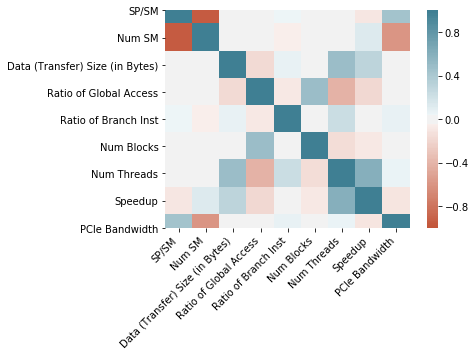

In [5]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

####  Covariance

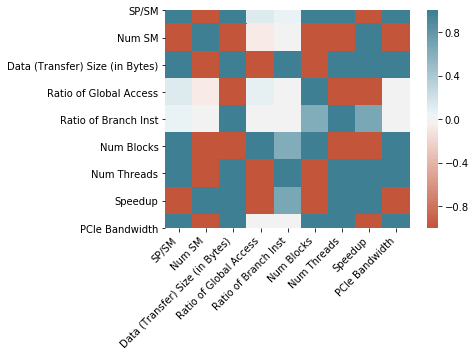

In [6]:
cov = df.cov()
ax = sns.heatmap(
    cov, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Train Test Split after featue-target split. Then training data is standardized.

In [7]:
#features-target split
y = df['Speedup'].values
df = df.drop(['Speedup'], axis=1)
X = df.values

#standardizing
scaler = StandardScaler()
X=scaler.fit_transform(X)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [8]:
type(y_train)

numpy.ndarray

### Naive Baseline

Naive baseline is to guess the median value on the training set. If the model cannot better this basic baseline, then nope!

In [9]:
# Naive baseline is the median
median_pred = np.median(y_train) #X_train['Speedup'].median()
median_preds = [median_pred for _ in range(len(y_train))]
true = y_train

# Display the naive baseline metrics
mb_mae = metrics.mean_absolute_error(true, median_preds)
mb_rmse = np.sqrt(metrics.mean_squared_error(true, median_preds))
mb_mse = metrics.mean_squared_error(true, median_preds)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline  MSE: {:.4f}'.format(mb_mse))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 515.2048
Median Baseline  MSE: 2620920.2503
Median Baseline RMSE: 1618.9256


### Random Forest

In [10]:
#Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 23.078041671873105
Mean Squared Error: 2013.5303610095439
Root Mean Squared Error: 44.87237859763558


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 40, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 10, 11, 12, 13, 13, 14, 15, 16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 23, 24, 25, 26, 26, 27, 28, 29, 30, 30, 31, 32, 33, 33, 34, 35, 36, 36, 37, 38, 39, 40], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [12]:
rf = RandomForestRegressor(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.2s finished
C:\Users\poorn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [13]:
rf_random.best_params_

{'n_estimators': 26,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [14]:
#Random Forest Regressor
# regressor = RandomForestRegressor(n_estimators=891, min_samples_split=5,min_samples_leaf=2,max_features='sqrt',max_depth=60,
#  bootstrap=True, random_state=0)
rf_random.best_estimator_.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

##random forest better without FP

Mean Absolute Error: 23.078041671873105
Mean Squared Error: 2013.5303610095439
Root Mean Squared Error: 44.87237859763558


### SVR

In [15]:
#Support Vector Machine Regressor
regressor = SVR(kernel='rbf') #try different kernels
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 173.00385785713544
Mean Squared Error: 257627.48408722025
Root Mean Squared Error: 507.5701765147557


C:\Users\poorn\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### ElasticNet Regression

In [16]:
#ENet Regression
regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 368.7734824626983
Mean Squared Error: 202551.14985628292
Root Mean Squared Error: 450.0568295852013


### Linear Regression

In [17]:
#Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 386.972547297676
Mean Squared Error: 286626.3813143183
Root Mean Squared Error: 535.3749913045232


### Gradient Boosted Trees

In [18]:
#GBT
regressor = GradientBoostingRegressor(n_estimators=20)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 113.68052437900661
Mean Squared Error: 40415.315225915256
Root Mean Squared Error: 201.0356068608625


### Multi-Layer Perceptron

In [19]:
#Multi-Layer Perceptron
regressor = MLPRegressor(hidden_layer_sizes=(10,10,10), activation='relu', solver='adam', max_iter=5000, random_state=100)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 44.48661463225307
Mean Squared Error: 8259.253775184148
Root Mean Squared Error: 90.88043670220863


C:\Users\poorn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Gaussian Process Regression

In [20]:
gp_kernel = DotProduct() + WhiteKernel()
regressor = GaussianProcessRegressor(kernel=gp_kernel)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

#evalaute
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 537.8454353858144
Mean Squared Error: 343100.673912406
Root Mean Squared Error: 585.7479610825854


MLP Ops <br>
hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000, random_state=100
Mean Absolute Error: 45.23302838607476
Mean Squared Error: 8191.491847308867
Root Mean Squared Error: 90.5068607747991
    
hidden_layer_sizes=(10,10,10), activation='relu', solver='adam', max_iter=5000, random_state=100
Mean Absolute Error: 44.48661463225307
Mean Squared Error: 8259.253775184148
Root Mean Squared Error: 90.88043670220863